You need to install OpendCV to run the calibration and to undistort the images later. For that ran the two commands from below in a terminal in Jupyter.

```bash
sudo apt update
sudo apt install python3-opencv
```

The next code is based on this article https://medium.com/@kennethjiang/calibrate-fisheye-lens-using-opencv-333b05afa0b0. Pleas read it before running the code.

However, after we undistort the images we will lose part of it. Check part 2 of the tutorial if you want to recover the cropped part of the undistorted image.

In [0]:
import cv2
from picamera.array import PiYUVArray
from picamera import PiCamera
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [0]:
camera = PiCamera()
        
# Check the link below for the combinations between mode and resolution
# https://picamera.readthedocs.io/en/release-1.13/fov.html#sensor-modes
res = (640, 480)
camera.sensor_mode = 7
camera.resolution = res # you must calibrate for each different resolution
camera.framerate = 10

# Initialize the buffer and start capturing
rawCapture = PiYUVArray(camera, size=res)
stream = camera.capture_continuous(rawCapture, format="yuv", use_video_port=True)

In [0]:
imgCounter = 0

# Initialize properly sized arrays and some other openCV preparation steps
CHECKERBOARD = (4,4) # this tuple must contain the number of color changes per column and line respectively 
# (which equals number of squares minus 1)

subpix_criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1)
calibration_flags = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC+cv2.fisheye.CALIB_FIX_SKEW + cv2.fisheye.CALIB_CHECK_COND
                        
objp = np.zeros((1, CHECKERBOARD[0]*CHECKERBOARD[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)

objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.


## Attention
Run the next block of code several times to capture the checkerboard at different positions similar to the pictures in the article. About 8 - 10 pictures should be enough if the checker board covers all the parts of the image.

Success! Youve captured 5 good images so far.


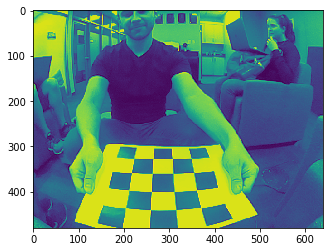

In [0]:
# Capture image
rawCapture.truncate(0)
frame = next(stream)
I = frame.array[:, :, 0]

# Find the chess board corners
ret, corners = cv2.findChessboardCorners(I, 
                                         CHECKERBOARD, cv2.CALIB_CB_ADAPTIVE_THRESH+cv2.CALIB_CB_FAST_CHECK+cv2.CALIB_CB_NORMALIZE_IMAGE)

# Check if captured image
if ret == True:
    imgCounter+=1
    print('Success! You''ve captured ' + str(imgCounter) + ' good images so far.')
    objpoints.append(objp)
    cv2.cornerSubPix(I,corners,(3,3),(-1,-1),subpix_criteria)
    imgpoints.append(corners)
else:
    print('Corners not detected :( \n Try again')

plt.imshow(I)

After getting enough images with the checkerbox at different positions, obtain the K and D arrays. If you don't get enough good images, this code will raise an error

In [0]:
N_OK = len(objpoints)
K = np.zeros((3, 3))
D = np.zeros((4, 1))
rvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
tvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
rms, _, _, _, _ = \
    cv2.fisheye.calibrate(
        objpoints,
        imgpoints,
        I.shape[::-1],
        K,
        D,
        rvecs,
        tvecs,
        calibration_flags,
        (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)
    )

print("Found " + str(N_OK) + " valid images for calibration")
print("DIM=" + str(I.shape[::-1]))
print("K=np.array(" + str(K.tolist()) + ")")
print("D=np.array(" + str(D.tolist()) + ")")

DIM = I.shape[::-1]
map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), K, DIM, cv2.CV_16SC2)

# Save map1 and map2 somewhere so you don't need to recalibrate your camera everytime
with open("camera-parameters.pkl", "wb") as f:
    pickle.dump([map1, map2], f)

Found 5 valid images for calibration
DIM=(640, 480)
K=np.array([[348.0981790689992, 0.0, 317.64896850819736], [0.0, 344.07147752602833, 234.0789332585976], [0.0, 0.0, 1.0]])
D=np.array([[0.20319215541991775], [-1.0804296481248774], [1.8017142868387872], [-1.0048504224566688]])


In [0]:
# Load parameters (if needed)
with open("camera-parameters.pkl", "rb") as f:
    map1, map2 = pickle.load(f)

In [0]:
# Function to undistort captured images
def undistort_current_image(I, map1, map2 ):
    undistorted_img = cv2.remap(I, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
    return undistorted_img

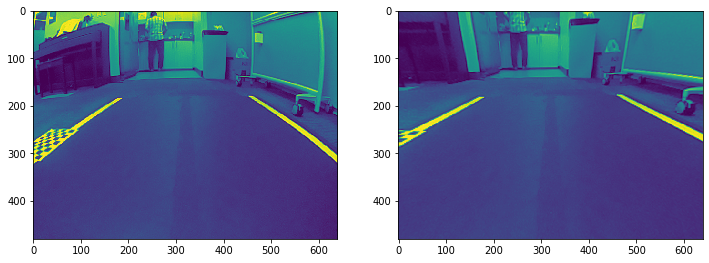

In [0]:
#Do a test:

rawCapture.truncate(0)
frame = next(stream)
I = frame.array[:, :, 0]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(I)
plt.subplot(1, 2, 2)
plt.imshow(undistort_current_image(I, map1, map2))

In [0]:
%%timeit
undistort_current_image(I)

3.71 ms ± 7.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [0]:
# Release resources
camera.close()
rawCapture.close()
stream.close()

NameError: name 'camera' is not defined